# Time Series Analysis and Forecasting of Liquor Sales in Iowa

## Content:
* Introduction
* Data Preparation
* Trend Extraction
* ARIMA modelling
* Validation
* Forecasting
* Compare brands
* Forecasting with Prophet
* Market Trend
* Concluding Remarks

## Introduction
This notebook analyses the trends that affect liqour sales in the state of Iowa, America and aims to forecast the compare the performace of competing brands. 

We will be utilising "Time Series Analysis" to extract trends and build "Auto Regressive Integrated Moving Average" (ARIMA) models to produce forecasts.  

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
import datetime
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

##  Data Preparation

In [ ]:
## Data Loading
file_path = '../input/iowa-liquor-sales/Iowa_Liquor_Sales.csv'
df = pd.read_csv(file_path)

In [ ]:
print(df.shape)
print(df.columns)
df.head()

The dataset consists of 24 columns and 12,591,077 rows.
The only columns we are interested in are; 'Date', 'Vendor Name' and 'Sale (Dollars)'. 

In [ ]:
df['Sale (Dollars)'] = df['Sale (Dollars)'].str.replace('$', '')
df['Sale (Dollars)'] = df['Sale (Dollars)'].astype('float')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].head(), df['Sale (Dollars)'].head()

Now that our datset has been properly processed and formatted. 
We are going focus on Jim Beam Brands, which has been producing bourbon for over 200 years out of Kentucky, America
with market capital of approximately $11.5 billion. 

In [ ]:
## Data Preprocessing
JBB = df.loc[df['Vendor Name'] == 'Jim Beam Brands']
cols = ['Invoice/Item Number', 'Store Number', 'Store Name', 'Address', 'City', 'Zip Code',
       'Store Location', 'County Number', 'County', 'Category', 'Category Name', 'Vendor Number',
       'Vendor Name', 'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)', 'State Bottle Cost',
        'State Bottle Retail', 'Bottles Sold', 'Volume Sold (Liters)', 'Volume Sold (Gallons)']
JBB.drop(cols, axis = 1, inplace = True)
JBB.isnull().sum()

JBB = JBB.groupby('Date')['Sale (Dollars)'].sum().reset_index()
JBB = JBB.set_index('Date')
JBB.index


 ## Trend Extraction


In [ ]:
## Time Series Analysis
JBB.head()
y = JBB['Sale (Dollars)'].resample('MS').mean()
y['2016':].describe()
y.plot()

At first glance, the sales for Jim Beam Brands appear to have high variability and difficult to interpret. 

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()


The trend reveals that sales have been only slightly increasing before 2016. 
During 2016 sales have been dropping and then seems to have flattended in 2017. 
It also appears that the sales have a periodicty of 12 months, which may explain the variability. 

## ARIMA modelling

Before we begin building the ARIMA model, we must select the optimal parameters (p, d, q, t).
Since we have already established that the periodicity is 12 months, we can let t = 12. 
In order to determine the estimates for p, d & q, we will simulate all combinations of the parameters and select the model with the lowest AIC score. 

In [ ]:
# Parameter Tuning
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue


The optimal model has p = 0, d = q = 1.

In [ ]:
# Fitting Model
mod = sm.tsa.statespace.SARIMAX(y,
                                order = (0,1,1),
                                seasonal_order = (0,1,1,12),
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize = (16,8))

## Validation

To validate the we will generate prediction for the final year (2016-Oct - 2017-Oct) and compare it to the observed values over the same time period. 

In [ ]:
# Validation
pred = results.get_prediction(start=pd.to_datetime('2016-11-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

THe RMSE, 15621, is a bit high for our model which suggests that it is not the best fit for the data.  

## 4. Forecasting


In [ ]:
# Forecasting
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Sales ($)')
ax.set_title('Jim Beam')
plt.legend()

Based on the forecast produced by the model, we can expect to see the sales for Jim  Beam Brands to steadily decline
with minor boosts due to seasonality. 

## 5. Comparing Brands

Wilson Daniels Ltd is a marketing & sales company that represents a variety of smaller wineries and distilleries thats only been around in the last decade.
We will now compare the sales of Jim Beam Brands and Wilson Daniels Ltd.

In [ ]:
## Comparing Vendor/Brands
df['Vendor Name'].drop_duplicates().values
WDL = df.loc[df['Vendor Name'] == 'Wilson Daniels Ltd.']
JBB = df.loc[df['Vendor Name'] == 'Jim Beam Brands']

JBB.drop(cols, axis = 1, inplace = True)
WDL.drop(cols, axis = 1, inplace = True)
JBB.isnull().sum()
WDL.isnull().sum()

JBB = JBB.groupby('Date')['Sale (Dollars)'].sum().reset_index()
WDL = WDL.groupby('Date')['Sale (Dollars)'].sum().reset_index()
JBB = JBB.set_index('Date')
WDL = WDL.set_index('Date')
JBB.index
WDL.index

In [ ]:
y_JBB = JBB['Sale (Dollars)'].resample('MS').mean()
y_WDL = WDL['Sale (Dollars)'].resample('MS').mean()
JBB = pd.DataFrame({'Date': y_JBB.index, 'Sale (Dollars)': y_JBB.values})
WDL = pd.DataFrame({'Date': y_WDL.index, 'Sale (Dollars)': y_WDL.values})

vendor = JBB.merge(WDL, how = 'inner', on = 'Date')
vendor.rename(columns = {'Sale (Dollars)_x': 'Jim Beam Sales', 'Sale (Dollars)_y': 'Wilson Daniels Ltd Sales'}, inplace = True)
vendor.head()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(vendor['Date'], vendor['Jim Beam Sales'], 'b-', label = 'Jim Beam')
plt.plot(vendor['Date'], vendor['Wilson Daniels Ltd Sales'], 'r-', label = 'Wilson Daniels')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of Jim Beam and Wilson Daniels')
plt.legend()

## Forecasting with Prophet

Using the package Prophet, we are able to generate more accurate forecasts without going through the hassle of manually building the ARIMA model.

In [ ]:
## Forecasting with Prophet
from fbprophet import Prophet

JBB = JBB.rename(columns = {'Date': 'ds', 'Sale (Dollars)': 'y'})
JBB_model = Prophet(interval_width = 0.95)
JBB_model.fit(JBB)

WDL = WDL.rename(columns = {'Date': 'ds', 'Sale (Dollars)': 'y'})
WDL_model = Prophet(interval_width = 0.95)
WDL_model.fit(WDL)

JBB_forecast = JBB_model.make_future_dataframe(periods=36, freq = 'MS')
JBB_forecast = JBB_model.predict(JBB_forecast)

WDL_forecast = WDL_model.make_future_dataframe(periods = 36, freq = 'MS')
WDL_forecast = WDL_model.predict(WDL_forecast)

In [ ]:
plt.figure(figsize=(18,6))
JBB_model.plot(JBB_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Jim Beam Sales with Forecasts')

Note that the Jim Beam Sales forecast produced by our ARIMA model and the model using Prophet are remarkably similar. 

In [ ]:
plt.figure(figsize=(18,6))
WDL_model.plot(WDL_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Wilson Daniels Sales with Forecasts')

Both forecasts suggest that sales will continue to decline into the ensuing years. 
So lets take a closer look at the trends for Jim Beam and wilson Daniels.
Below, we see that Jim Beam Brands, trading as Suntory Beverage & Food Ltd seems to confirm our predictions. 

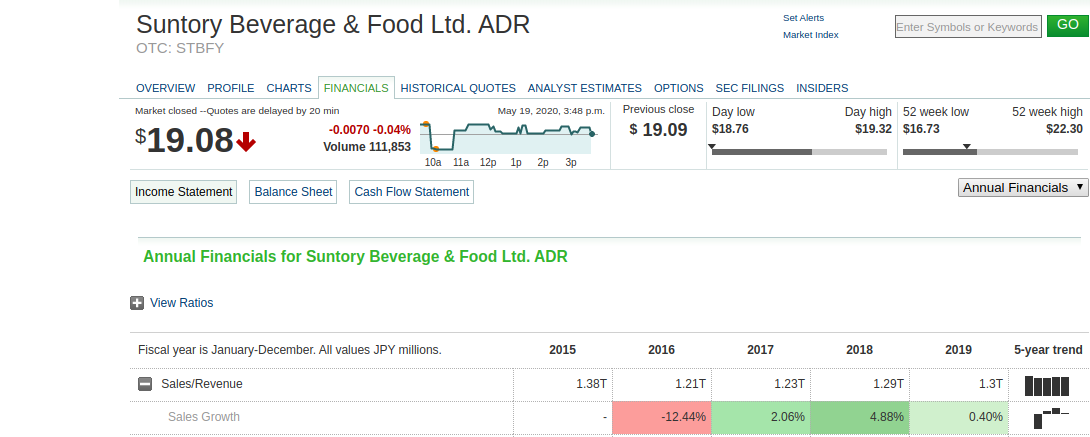
Source: https://www.marketwatch.com/investing/stock/stbfy

In [ ]:
JBB_names = ['JBB_%s' % column for column in JBB_forecast.columns]
WDL_names = ['WDL_%s' % column for column in WDL_forecast.columns]

merge_JBB_forecast = JBB_forecast.copy()
merge_WDL_forecast = WDL_forecast.copy()
merge_JBB_forecast.columns = JBB_names
merge_WDL_forecast.columns = WDL_names

forecast = pd.merge(merge_JBB_forecast, merge_WDL_forecast, how = 'inner', left_on = 'JBB_ds', right_on = 'WDL_ds')
forecast = forecast.rename(columns = {'JBB_ds': 'Date'}).drop('WDL_ds', axis = 1)
forecast.head()

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(forecast['Date'], forecast['JBB_trend'], 'b-')
plt.plot(forecast['Date'], forecast['WDL_trend'], 'r-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Jim Beam vs Wilson Daniels Trend')
plt.legend()

This confirm our initial suspicion and may be indicative of the market forces. 

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(forecast['Date'], forecast['JBB_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['WDL_yhat'], 'r-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Jim Beam vs Wilson Daniels Estimate')
plt.legend()

## Market Trend
Although we may not have access to liquor sales access all of America, we will use the Iowa liquor sales dataset as a representative sample of the American liquor market.  

In [ ]:
df1 =df.copy()
df1.drop(cols, axis = 1, inplace = True)
df1 = df1.groupby('Date')['Sale (Dollars)'].sum().reset_index()
df1 = df1.set_index('Date')
y = df1['Sale (Dollars)'].resample('MS').mean()

df1 = pd.DataFrame({'Date': y.index, 'Sale (Dollars)': y.values})
df1 = df1.rename(columns ={'Date': 'ds', 'Sale (Dollars)': 'y'} )
df1_model = Prophet(interval_width = 0.95)
df1_model.fit(df1)

df1_forecast = df1_model.make_future_dataframe(periods = 36, freq = 'MS')
df1_forecast = df1_model.predict(df1_forecast)

In [ ]:
plt.figure(figsize = (18,6))
df1_model.plot(df1_forecast, xlabel = 'Date', ylabel = 'Sales ($)')
plt.title('Liquor Market')


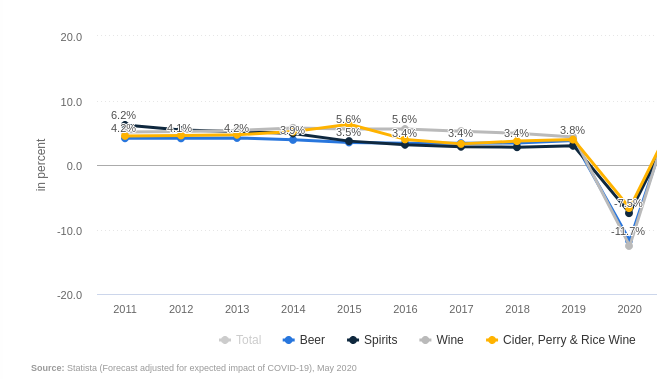

## Concluding Remarks: 
The market forecasts predict a steady decline in sales which are in line with trends shown for Jim Beam and Wilson Daniels.
Fortunately, we have the luxury to validate our predictions and can see that they show a similar behaviour to the observations. 

This notebook was a prooof-of-concept that demonstrates the power of time-series analysis in anlaysis of data and how it can be used to inform our decisions about the future. 
So please feel free to UPVOTE if you liked this notebook and any feedback would be appreciated

